# UJIIndoorLoc

In [1]:

import os


requirements_path = os.path.join(os.getcwd(), 'requirements.txt')

os.system(f'pip install -r {requirements_path}')
print("All dependencies have been installed.")

All dependencies have been installed.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#import sklearn measures




# 1. Read Data into Dataframe

In [3]:
datafolder = "../../datasets/UJIIndoorLoc"

trainfile = os.path.join(datafolder, "trainingData.csv")
validfile = os.path.join(datafolder, "validationData.csv")

#read data into pandas dataframes
train_data = pd.read_csv(trainfile)
test_data = pd.read_csv(validfile)
print("Training data shape:", train_data.shape)
test_data.head()




Training data shape: (19937, 529)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774


In [4]:
# Response variables in our problem are Building, Floor, Latitude, Longitude and Relative Position
train_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])
test_data[['FLOOR','BUILDINGID', 'SPACEID','RELATIVEPOSITION','USERID','PHONEID']].astype(str).describe(include=['object'])

## X and Y-data split
# Features are the WAP columns
X_train = train_data.iloc[:,:520]
X_test = test_data.iloc[:,:520]

# Select FLOOR and BUILDINGID for location prediction
y_train = train_data[['FLOOR', 'BUILDINGID', 'SPACEID']].copy()
y_test  = test_data[['FLOOR', 'BUILDINGID']].copy()
y_train_new_predict = y_train.copy()

print(y_test.head())

#histogram of space ids for test set
# Combine BUILDINGID and FLOOR into a simpler location code
# Format: "B{BUILDING}F{FLOOR}" for better readability
y_train_new_predict['LOC_CODE'] = (y_train['BUILDINGID'].astype(str) + 
                       y_train['FLOOR'].astype(str)+
                       y_train['SPACEID'].astype(str)
                       )
y_train['LOC_CODE'] = (y_train['BUILDINGID'].astype(str) + 
                       y_train['FLOOR'].astype(str)
                       )
y_test['LOC_CODE'] = (y_test['BUILDINGID'].astype(str) + 
                      y_test['FLOOR'].astype(str) 
                      )

# Keep only the combined column
y_train = y_train[['LOC_CODE']].astype('category')
y_test  = y_test[['LOC_CODE']].astype('category')
y_train_new_predict = y_train_new_predict[['LOC_CODE']].astype('category')

y_train_new_predict.head()


   FLOOR  BUILDINGID
0      1           1
1      4           2
2      4           2
3      4           2
4      2           0


,LOC_CODE
0,12106
1,12106
2,12103
3,12102
4,00122


# 2. Exploratory Data Analysis

In [5]:
# Replace the 100 values with NaN for further processing
# Transform Train data
X_train = (X_train
             .replace(to_replace=100,value=np.nan))

# Perform the same transform on Test data
X_test = (X_test
             .replace(to_replace=100,value=np.nan))

### drop NaN and show distribution

count    358763.000000
mean        -78.497211
std          12.615758
min        -104.000000
25%         -88.000000
50%         -82.000000
75%         -72.000000
max           0.000000
dtype: float64

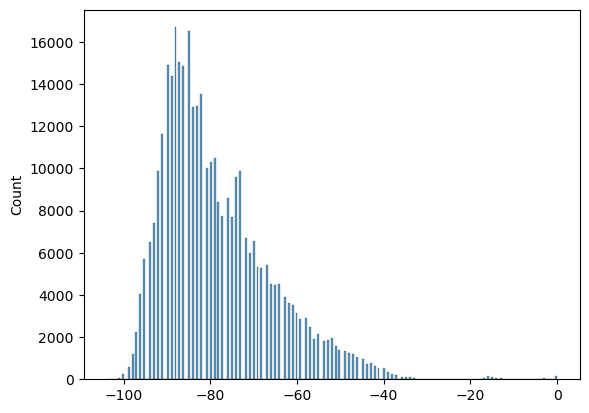

In [6]:
X_stack = X_train.stack(future_stack=True)
sns.histplot(X_stack.dropna(),kde = False)
X_stack.describe()

In [7]:
# Proportion of out of range values
sum(X_stack.isnull() == 0)/len(X_stack)

0.03460544947353394

In [6]:
# Removing columns with all NaN values
all_nan = (X_train
           .isnull()
           .all(axis=0) == False)
filtered_cols = (all_nan[all_nan]
                 .index
                 .values)

print("Before removing predictors with no in-range values", X_train.shape)

X_train = X_train.loc[:,filtered_cols]
X_test = X_test.loc[:,filtered_cols]

print("After removing predictors with no in-range values", X_train.shape)

Before removing predictors with no in-range values (19937, 520)
After removing predictors with no in-range values (19937, 465)


In [ ]:
X_raw_train = X_train
X_raw_test = X_test

X_raw_combined = pd.concat([X_raw_train, X_raw_test], axis=0)
Y_raw_combined = pd.concat([y_train, y_test], axis=0)

#new test train split
X_train_tot_split, X_test__tot_split, Y_train_tot_split, Y_test__tot_split = train_test_split(X_raw_combined, Y_raw_combined, test_size=0.2, random_state=42, stratify=Y_raw_combined)
X_train_split_new, X_test_split_new, Y_train_split_new, Y_test_split_new = train_test_split(X_raw_train, y_train_new_predict, test_size=0.2, random_state=42, stratify=y_train_new_predict)


#PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_tot_split)
X_test_pca = pca.transform(X_test__tot_split)
print(f"Original number of features: {X_train_tot_split.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")


#fill for SCaling
X_train_noNAN = X_train.fillna(-110)
X_test_noNAN = X_test.fillna(-110)


X_raw_train.shape, X_raw_test.shape, X_train_split_new.shape, X_test_split_new.shape, Y_train_split_new.shape, Y_test_split_new.shape


((19937, 465), (1111, 465), (15949, 465), (3988, 465), (15949, 1), (3988, 1))

count    1111.000000
mean       15.591359
std         6.233626
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        33.000000
dtype: float64

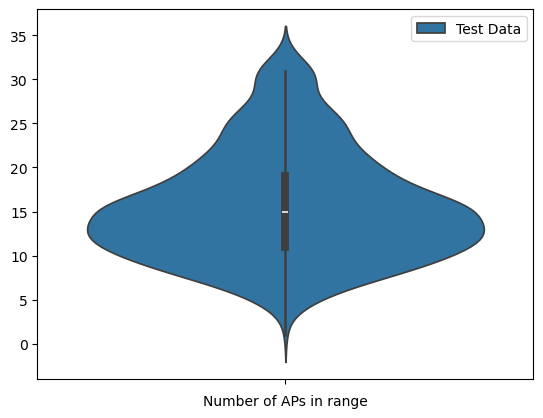

In [10]:
waps_in_range_train = (X_train
                 .notnull()
                 .sum(axis = 1))

waps_in_range_test = (X_test
                 .notnull()
                 .sum(axis = 1))

waps_in_range_tot_train_split = (X_train_tot_split
                 .notnull() 
                 .sum(axis = 1))
waps_in_range_tot_test_split = (X_test__tot_split
                 .notnull() 
                 .sum(axis = 1))

fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_test, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_test.describe()

count    19937.000000
mean        17.994834
std          7.333575
min          0.000000
25%         13.000000
50%         17.000000
75%         22.000000
max         51.000000
dtype: float64

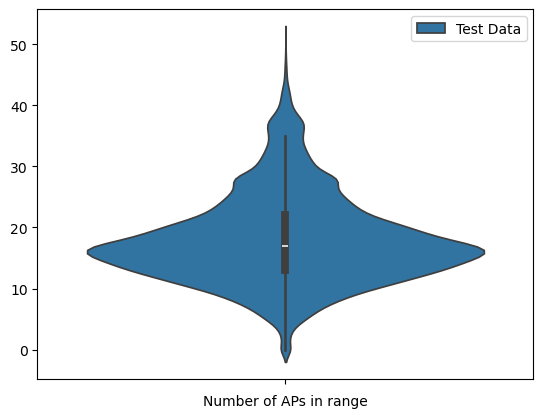

In [11]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_train, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_train.describe()

count    4210.000000
mean       17.808551
std         7.221304
min         0.000000
25%        13.000000
50%        17.000000
75%        22.000000
max        44.000000
dtype: float64

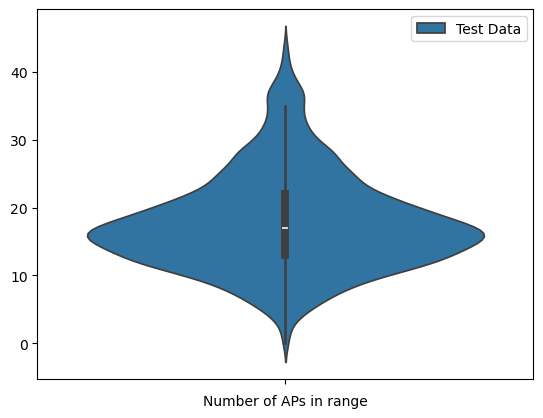

In [12]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_tot_test_split, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_tot_test_split.describe()

count    16838.000000
mean        17.882825
std          7.318876
min          0.000000
25%         13.000000
50%         17.000000
75%         21.000000
max         51.000000
dtype: float64

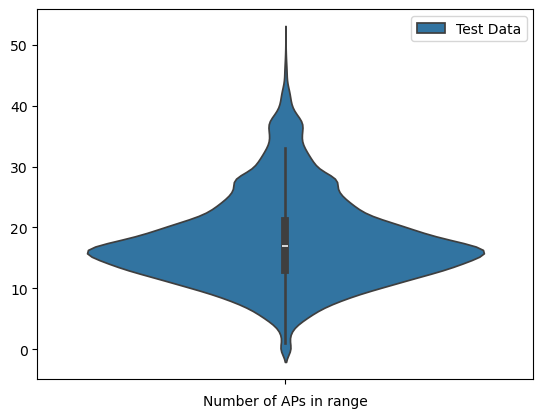

In [13]:
fig, ax = plt.subplots(1,1)


sns.violinplot(waps_in_range_tot_train_split, ax = ax, label = 'Test Data')
ax.set_xlabel("Number of APs in range")
ax.legend()
waps_in_range_tot_train_split.describe()

## 3. Feature scaling

<Axes: ylabel='Count'>

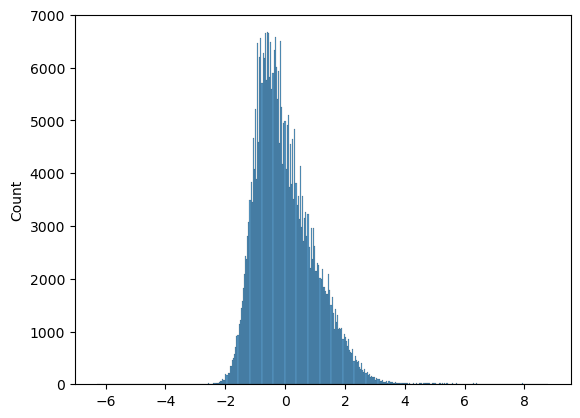

In [14]:

sc = StandardScaler()
X_std_train = sc.fit_transform(X_raw_train)
X_std_test = sc.transform(X_raw_test)

X_std_train = pd.DataFrame(X_std_train)
X_std_test = pd.DataFrame(X_std_test)

##plotting standardized data distribution
X_stack_std = X_std_train.stack(future_stack=True)
sns.histplot(X_stack_std.dropna(),kde = False)


## Random Forest can work with NaNs

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes
Y_train_tot_split_codes = Y_train_tot_split['LOC_CODE'].cat.codes
Y_test__tot_split_codes = Y_test__tot_split['LOC_CODE'].cat.codes

print(f"Number of unique locations: {y_train['LOC_CODE'].nunique()}")
print(f"Training samples: {len(y_train_codes)}, Test samples: {len(y_test_codes)}")

# Train classifier with scaling
# clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# clf.fit(X_std_train, y_train_codes)

# clf_wo_scaling = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, criterion='entropy',max_features=None)
# clf_wo_scaling.fit(X_raw_train, y_train_codes)

clf_woscaling_newsplit = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
clf_woscaling_newsplit.fit(X_train_tot_split, Y_train_tot_split_codes)

# Predict on test set
y_pred = clf.predict(X_std_test)
y_pred_wo_scaling = clf_wo_scaling.predict(X_raw_test)
y_pred_woscaling_newsplit = clf_woscaling_newsplit.predict(X_test__tot_split)

# Evaluate
accuracy = accuracy_score(y_test_codes, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report with Scaling:")
accuracy_wo_scaling = accuracy_score(y_test_codes, y_pred_wo_scaling)
accuracy_woscaling_newsplit = accuracy_score(Y_test__tot_split_codes, y_pred_woscaling_newsplit)
classification_report = classification_report(y_test_codes, y_pred_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
#print(classification_report)
print(f"\nAccuracy without Scaling: {accuracy_wo_scaling:.4f}")
print(f"\nAccuracy with new train/test split: {accuracy_woscaling_newsplit:.4f}")
print("\nClassification Report without Scaling:")

# Show some example predictions
comparison = pd.DataFrame({
    'True': y_test['LOC_CODE'].values[:10],
    'Predicted': y_train['LOC_CODE'].cat.categories[y_pred[:10]]
})
print("\nFirst 10 predictions:")
print(comparison)








Number of unique locations: 13
Training samples: 19937, Test samples: 1111


NameError: name 'clf' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

clf_woscaling_spaceid = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1, criterion='log_loss', max_features='log2')
clf_woscaling_spaceid.fit(X_train_split_new, Y_train_split_new['LOC_CODE'].cat.codes)
y_pred_woscaling_spaceid = clf_woscaling_spaceid.predict(X_test_split_new)
accuracy_woscaling_spaceid = accuracy_score(Y_test_split_new['LOC_CODE'].cat.codes, y_pred_woscaling_spaceid)
print(f"\nAccuracy without Scaling with SPACEID: {accuracy_woscaling_spaceid:.4f}") 

# Get unique labels present in both test and predictions
unique_labels = np.unique(np.concatenate([Y_test_split_new['LOC_CODE'].cat.codes, y_pred_woscaling_spaceid]))

# Create mapping from codes to category names, handling out-of-range codes
all_categories = Y_train_split_new['LOC_CODE'].cat.categories
target_names = []
for code in unique_labels:
	if code < len(all_categories):
		target_names.append(all_categories[code])
	else:
		target_names.append(f"Unknown_{code}")

classification_report_spaceid = classification_report(
	Y_test_split_new['LOC_CODE'].cat.codes, 
	y_pred_woscaling_spaceid, 
	labels=unique_labels,
	target_names=Y_raw_combined['LOC_CODE'].cat.categories,
	zero_division=0
)
print(classification_report_spaceid)


Accuracy without Scaling with SPACEID: 0.8751
              precision    recall  f1-score   support

          00       0.80      1.00      0.89         4
          01       1.00      1.00      1.00         2
          02       1.00      1.00      1.00         2
          03       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         4
          11       0.75      0.75      0.75         4
          12       1.00      1.00      1.00         4
          13       1.00      1.00      1.00         4
          20       1.00      1.00      1.00         3
          21       1.00      1.00      1.00         2
          22       0.50      0.50      0.50         2
          23       1.00      0.67      0.80         3
          24       0.80      0.80      0.80         5

    accuracy                           0.88      3988
   macro avg       0.90      0.86      0.86      3988
weighted avg       0.90      0.88      0.88      3988



c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 734, does not match size of target_names, 13
  warnings.warn(


In [ ]:
sc = StandardScaler()
X_std_train_noNAN = sc.fit_transform(X_train_noNAN)
X_std_test_noNAN = sc.transform(X_test_noNAN)

X_std_train_noNAN = pd.DataFrame(X_std_train_noNAN)
X_std_test_noNAN = pd.DataFrame(X_std_test_noNAN)

#plot standardized data distribution
X_stack_std_noNAN = X_std_train_noNAN.stack(future_stack=True)
##sns.histplot(X_stack_std_noNAN,kde = False) not needed since NAN dominates

## KNN-Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Convert categorical LOC_CODE to numeric codes
y_train_codes = y_train['LOC_CODE'].cat.codes
y_test_codes = y_test['LOC_CODE'].cat.codes
# Train classifier
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(X_std_train_noNAN, y_train_codes)

knn_clf_wo_scaling = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf_wo_scaling.fit(X_train_noNAN, y_train_codes)
# Predict on test set
y_pred_knn = knn_clf.predict(X_std_test_noNAN)
y_pred_knn_wo_scaling = knn_clf_wo_scaling.predict(X_test_noNAN)
# Evaluate
accuracy_knn = accuracy_score(y_test_codes, y_pred_knn)
print(f"\nKNN Accuracy: {accuracy_knn:.4f}")
print("\nKNN Classification Report with Scaling:")
accuracy_knn_wo_scaling = accuracy_score(y_test_codes, y_pred_knn_wo_scaling)
print(f"\nKNN Accuracy without Scaling: {accuracy_knn_wo_scaling:.4f}")
print("\nKNN Classification Report without Scaling:")



classification_report_knn = classification_report(y_test_codes, y_pred_knn_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
print(classification_report_knn)

c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Das System kann die angegebene Datei nicht finden
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\JakobOlsacher\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JakobOlsacher\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
 


KNN Accuracy: 0.7921

KNN Classification Report with Scaling:

KNN Accuracy without Scaling: 0.8875

KNN Classification Report without Scaling:
              precision    recall  f1-score   support

          00       0.89      0.95      0.92        78
          01       0.96      0.97      0.96       208
          02       0.97      0.96      0.96       165
          03       1.00      0.98      0.99        85
          10       0.83      0.67      0.74        30
          11       0.95      0.63      0.76       143
          12       0.58      0.85      0.69        87
          13       0.79      0.96      0.87        47
          20       0.85      0.92      0.88        24
          21       0.95      0.97      0.96       111
          22       0.98      0.76      0.85        54
          23       0.72      0.97      0.83        40
          24       0.97      0.77      0.86        39

    accuracy                           0.89      1111
   macro avg       0.88      0.87      0.87

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
xgb_clf = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf.fit(X_std_train_noNAN, y_train_codes)
y_pred_xgb = xgb_clf.predict(X_std_test_noNAN)
accuracy_xgb = accuracy_score(y_test_codes, y_pred_xgb)
print(f"\nXGBoost Accuracy: {accuracy_xgb:.4f}")

xgb_clf_wo_scaling = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_clf_wo_scaling.fit(X_train_noNAN, y_train_codes)
y_pred_xgb_wo_scaling = xgb_clf_wo_scaling.predict(X_test_noNAN)
accuracy_xgb_wo_scaling = accuracy_score(y_test_codes, y_pred_xgb_wo_scaling)
print(f"\nXGBoost Accuracy without Scaling: {accuracy_xgb_wo_scaling:.4f}")

classification_report_xgb = classification_report(y_test_codes, y_pred_xgb_wo_scaling, target_names=y_train['LOC_CODE'].cat.categories)
print("\nXGBoost Classification Report without Scaling:")
print(classification_report_xgb)


XGBoost Accuracy: 0.8902

XGBoost Accuracy without Scaling: 0.8902

XGBoost Classification Report without Scaling:
              precision    recall  f1-score   support

          00       0.95      0.94      0.94        78
          01       0.97      0.91      0.94       208
          02       0.94      0.96      0.95       165
          03       0.99      0.96      0.98        85
          10       0.88      0.77      0.82        30
          11       0.97      0.62      0.76       143
          12       0.63      0.94      0.75        87
          13       0.73      0.87      0.80        47
          20       0.58      0.88      0.70        24
          21       0.94      0.97      0.96       111
          22       0.94      0.93      0.93        54
          23       0.87      1.00      0.93        40
          24       1.00      0.79      0.89        39

    accuracy                           0.89      1111
   macro avg       0.88      0.89      0.87      1111
weighted avg      

In [ ]:
## Performe KFold Cross-Validation for XGBoost
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_std_train_noNAN):
    X_train_fold, X_val_fold = X_std_train_noNAN.iloc[train_index], X_std_train_noNAN.iloc[val_index]
    y_train_fold, y_val_fold = y_train_codes.iloc[train_index], y_train_codes.iloc[val_index]
    
    xgb_clf_fold = XGBClassifier(eval_metric='mlogloss', random_state=42)
    xgb_clf_fold.fit(X_train_fold, y_train_fold)
    y_val_pred = xgb_clf_fold.predict(X_val_fold)
    y_test_pred = xgb_clf_fold.predict(X_std_test_noNAN)

    test_accuracy = accuracy_score(y_test_codes, y_test_pred)
    fold_accuracy = accuracy_score(y_val_fold, y_val_pred)
    print(f"Fold Accuracy: {fold_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

Fold Accuracy: 0.9955
Test Accuracy: 0.8857
Fold Accuracy: 0.9942
Test Accuracy: 0.8920
Fold Accuracy: 0.9942
Test Accuracy: 0.8920
Fold Accuracy: 0.9952
Test Accuracy: 0.8938
Fold Accuracy: 0.9952
Test Accuracy: 0.8938
Fold Accuracy: 0.9947
Test Accuracy: 0.8884
Fold Accuracy: 0.9947
Test Accuracy: 0.8884
Fold Accuracy: 0.9957
Test Accuracy: 0.8929
Fold Accuracy: 0.9957
Test Accuracy: 0.8929



Validation Accuracy (Train-Test Split): 0.9013

XGBoost Classification Report (Train-Test Split):
              precision    recall  f1-score   support

          00       0.89      0.89      0.89      1030
          01       0.86      0.91      0.88      1316
          02       0.82      0.73      0.78      1410
          03       0.87      0.88      0.88      1349
          10       0.95      0.82      0.88      1339
          11       0.80      0.89      0.84      1435
          12       0.90      0.87      0.88      1360
          13       0.89      0.90      0.90       907
          20       0.86      0.98      0.91      1876
          21       0.98      0.92      0.95      2105
          22       0.96      0.93      0.94      1518
          23       0.94      0.97      0.96      2620
          24       0.96      0.93      0.94      1074

    accuracy                           0.90     19339
   macro avg       0.90      0.89      0.90     19339
weighted avg       0.90      0.90  

Text(95.72222222222221, 0.5, 'True')

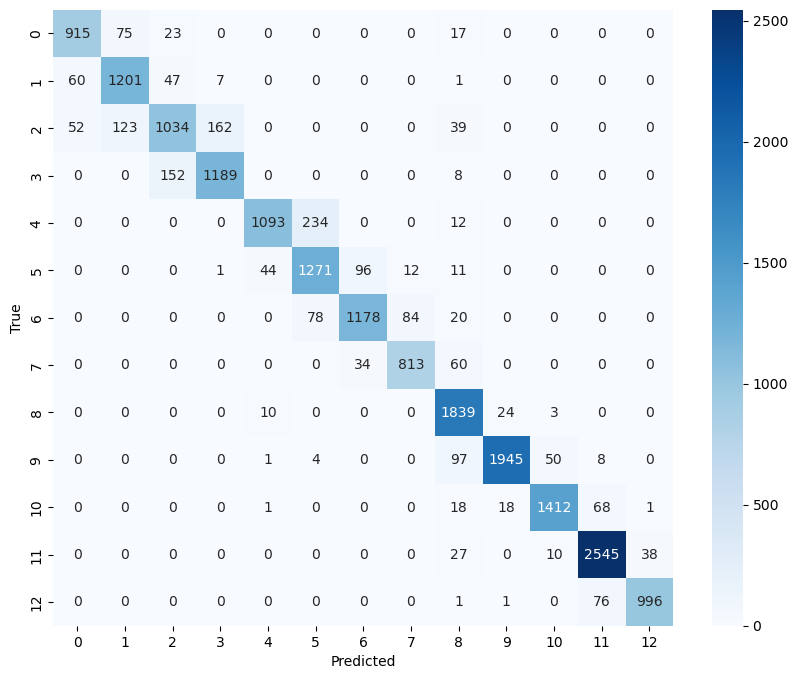

In [ ]:
## Train Test Split Validation for XGBoost
from sklearn.metrics import confusion_matrix
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_std_train_noNAN, y_train_codes, test_size=0.97, random_state=42
)   
xgb_clf_split = XGBClassifier(eval_metric='mlogloss', random_state=42, device='cuda')
xgb_clf_split.fit(X_train_split, y_train_split)
y_val_pred_split = xgb_clf_split.predict(X_val_split)
val_accuracy_split = accuracy_score(y_val_split, y_val_pred_split)
print(f"\nValidation Accuracy (Train-Test Split): {val_accuracy_split:.4f}")

classification_report_split = classification_report(y_val_split, y_val_pred_split, target_names=y_train['LOC_CODE'].cat.categories)
print("\nXGBoost Classification Report (Train-Test Split):")
print(classification_report_split)

confusion_matrix_split = confusion_matrix(y_val_split, y_val_pred_split)
print("\nXGBoost Confusion Matrix (Train-Test Split):")
print(confusion_matrix_split)

#plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_split, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

from classifierConfigs import get_classifier_configs, get_scorings, model_requires_int_labels
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##reload classifierConfigs
import importlib
import classifierConfigs as cc
importlib.reload(cc)

def make_preprocessor(scale: bool = False):
    """
    Return a transformer that imputes missing WAPs to -110 and
    optionally applies StandardScaler to all columns.
    Use in Pipeline as: ('preprocessor', make_preprocessor(scale=...))
    """
    if scale:
        transformer = Pipeline([
            ("imp", SimpleImputer(strategy="constant", fill_value=-110.0)),
            ("scaler", StandardScaler())
        ])
    else:
        transformer = SimpleImputer(strategy="constant", fill_value=-110.0)

    # Apply to all columns; ColumnTransformer is a valid transformer for Pipeline
    return ColumnTransformer(
        [("all_waps", transformer, slice(None))],
        remainder="drop"
    )






# Silence noisy worker warnings
import os, warnings
warnings.filterwarnings("ignore", message=".pkg_resources is deprecated as an API.", category=UserWarning)
os.environ.setdefault("PYTHONWARNINGS", "ignore:pkg_resources is deprecated as an API:UserWarning")
import importlib
import classifierConfigs as cc
importlib.reload(cc)

# Use the train/validation split already computed earlier in the notebook
# (X_train_split_new, X_test_split_new, Y_train_split_new, Y_test_split_new)
# Ensure label Series are 1D and contain the LOC_CODE category
X_train = X_train_split_new
X_val = X_test_split_new
y_train = Y_train_split_new['LOC_CODE'].astype('category')
y_val = Y_test_split_new['LOC_CODE'].astype('category')

# Integer-coded labels for models that require them (e.g., some XGBoost multiclass setups)
y_train_int = y_train.cat.codes
y_val_int = y_val.cat.codes

# Task selection: 'multiclass' or 'binary'
task = 'multiclass'

# Multi-metric scoring and configs by task
scoring = get_scorings(multiclass=(task == 'multiclass'))
refit_metric = "f1_macro"
configs = get_classifier_configs(task=task)

results_dir = "artifacts/gridsearch"
os.makedirs(results_dir, exist_ok=True)
all_results = []

for name, cfg in configs.items():
    print(f"Running Grid Search for {name}...")
    scale_TF = name.lower().startswith('knn')  # Scale only for KNN
    pipe = Pipeline(steps=[
        ('preprocessor', make_preprocessor(scale=scale_TF)),
        ('classifier', cfg['model'])
    ])

    param_grid = {f'classifier__{k}': v for k, v in cfg['param_grid'].items()}

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring=scoring,
        refit=refit_metric,
        n_jobs=1,
        verbose=3,
        cv=3
    )

    # Pick correct label vector for fitting: integer codes only if the model requires them
    y_fit = y_train_int if (task == 'multiclass' and model_requires_int_labels(name)) else y_train
    gs.fit(X_train, y_fit)

    # Save per-model CV results
    res_df = pd.DataFrame(gs.cv_results_)
    rank_col = f'rank_test_{refit_metric}' if f'rank_test_{refit_metric}' in res_df.columns else ('rank_test_score' if 'rank_test_score' in res_df.columns else None)
    if rank_col is not None:
        res_df = res_df.sort_values(rank_col)
    res_df.insert(0, 'model', name)
    res_df.insert(1, 'scoring', refit_metric)
    res_df['preproc_scaled'] = scale_TF
    out_path = os.path.join(results_dir, f"{name.replace(' ', '')}_cv_results{refit_metric}.csv")
    res_df.to_csv(out_path, index=False)
    all_results.append(res_df)

    print(f"Best parameters for {name}: {gs.best_params_} | Best {refit_metric}: {gs.best_score_:.4f}")

    # Predict on validation set and decode integer labels back to category names if needed
    y_val_pred = gs.predict(X_val)
    if task == 'multiclass' and model_requires_int_labels(name):
        # Map integer codes back to category labels using the training categories
        categories = y_train.cat.categories
        y_val_pred = pd.Series(y_val_pred).map(lambda c: categories[c] if (isinstance(c, (int, np.integer)) and c < len(categories)) else str(c)).values

    # Ensure y_val is plain array-like of labels (strings/categories) for reporting
    y_val_labels = y_val.values if hasattr(y_val, 'values') else y_val

    print(f"Validation Classification Report for {name}:\n")
    print(classification_report(y_val_labels, y_val_pred, zero_division=0))
    print("-" * 80)

if all_results:
    pd.concat(all_results, ignore_index=True).to_csv(
        os.path.join(results_dir, f"UJIIndoorLoc_ALL_cv_results_{refit_metric}.csv"),
        index=False
    )


Running Grid Search for Random Forest_adapt...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=entropy, classifier__max_features=None; accuracy: (test=0.771) f1_macro: (test=0.760) precision_macro: (test=0.809) recall_macro: (test=0.757) total time=  32.2s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=entropy, classifier__max_features=None; accuracy: (test=0.769) f1_macro: (test=0.754) precision_macro: (test=0.805) recall_macro: (test=0.752) total time=  32.1s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=entropy, classifier__max_features=None; accuracy: (test=0.768) f1_macro: (test=0.757) precision_macro: (test=0.805) recall_macro: (test=0.755) total time=  32.1s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=entropy, classifier__max_features=sqrt; accuracy: (test=0.827) f1_macro: (test=0.813) precision_macro: (test=0.864) recall_macro: (test=0.807) total time=   7.8s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=entropy, classifier__max_features=sqrt; accuracy: (test=0.831) f1_macro: (test=0.817) precision_macro: (test=0.869) recall_macro: (test=0.811) total time=   8.0s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=entropy, classifier__max_features=sqrt; accuracy: (test=0.828) f1_macro: (test=0.813) precision_macro: (test=0.863) recall_macro: (test=0.809) total time=   8.0s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=entropy, classifier__max_features=log2; accuracy: (test=0.819) f1_macro: (test=0.805) precision_macro: (test=0.856) recall_macro: (test=0.799) total time=   8.2s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=entropy, classifier__max_features=log2; accuracy: (test=0.817) f1_macro: (test=0.798) precision_macro: (test=0.852) recall_macro: (test=0.793) total time=   8.5s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=entropy, classifier__max_features=log2; accuracy: (test=0.820) f1_macro: (test=0.805) precision_macro: (test=0.854) recall_macro: (test=0.800) total time=   8.2s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=gini, classifier__max_features=None; accuracy: (test=0.813) f1_macro: (test=0.806) precision_macro: (test=0.851) recall_macro: (test=0.802) total time=  29.3s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=gini, classifier__max_features=None; accuracy: (test=0.815) f1_macro: (test=0.803) precision_macro: (test=0.847) recall_macro: (test=0.800) total time=  29.6s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=gini, classifier__max_features=None; accuracy: (test=0.811) f1_macro: (test=0.797) precision_macro: (test=0.843) recall_macro: (test=0.794) total time=  38.7s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=gini, classifier__max_features=sqrt; accuracy: (test=0.846) f1_macro: (test=0.835) precision_macro: (test=0.879) recall_macro: (test=0.830) total time=   7.2s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=gini, classifier__max_features=sqrt; accuracy: (test=0.847) f1_macro: (test=0.832) precision_macro: (test=0.876) recall_macro: (test=0.828) total time=   7.5s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=gini, classifier__max_features=sqrt; accuracy: (test=0.852) f1_macro: (test=0.837) precision_macro: (test=0.882) recall_macro: (test=0.832) total time=   7.5s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=gini, classifier__max_features=log2; accuracy: (test=0.841) f1_macro: (test=0.828) precision_macro: (test=0.873) recall_macro: (test=0.823) total time=   6.8s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=gini, classifier__max_features=log2; accuracy: (test=0.846) f1_macro: (test=0.831) precision_macro: (test=0.878) recall_macro: (test=0.826) total time=   6.9s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=gini, classifier__max_features=log2; accuracy: (test=0.850) f1_macro: (test=0.834) precision_macro: (test=0.877) recall_macro: (test=0.829) total time=   6.9s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=log_loss, classifier__max_features=None; accuracy: (test=0.772) f1_macro: (test=0.761) precision_macro: (test=0.813) recall_macro: (test=0.758) total time=  32.7s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=log_loss, classifier__max_features=None; accuracy: (test=0.775) f1_macro: (test=0.761) precision_macro: (test=0.812) recall_macro: (test=0.758) total time=  33.1s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=log_loss, classifier__max_features=None; accuracy: (test=0.766) f1_macro: (test=0.753) precision_macro: (test=0.801) recall_macro: (test=0.752) total time= 2.1min


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=log_loss, classifier__max_features=sqrt; accuracy: (test=0.827) f1_macro: (test=0.812) precision_macro: (test=0.861) recall_macro: (test=0.806) total time=   7.9s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=log_loss, classifier__max_features=sqrt; accuracy: (test=0.832) f1_macro: (test=0.813) precision_macro: (test=0.865) recall_macro: (test=0.809) total time=   8.0s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=log_loss, classifier__max_features=sqrt; accuracy: (test=0.827) f1_macro: (test=0.812) precision_macro: (test=0.861) recall_macro: (test=0.808) total time=   7.9s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 1/3] END classifier__criterion=log_loss, classifier__max_features=log2; accuracy: (test=0.820) f1_macro: (test=0.803) precision_macro: (test=0.855) recall_macro: (test=0.798) total time=   8.2s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__criterion=log_loss, classifier__max_features=log2; accuracy: (test=0.825) f1_macro: (test=0.808) precision_macro: (test=0.860) recall_macro: (test=0.803) total time=   8.3s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__criterion=log_loss, classifier__max_features=log2; accuracy: (test=0.822) f1_macro: (test=0.807) precision_macro: (test=0.856) recall_macro: (test=0.802) total time=   8.2s


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


Best parameters for Random Forest_adapt: {'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt'} | Best f1_macro: 0.8344
Validation Classification Report for Random Forest_adapt:

              precision    recall  f1-score   support

       00102       0.80      1.00      0.89         4
       00106       1.00      1.00      1.00         2
       00107       1.00      1.00      1.00         2
       00110       1.00      1.00      1.00         2
       00111       1.00      1.00      1.00         4
       00112       0.80      1.00      0.89         4
       00113       1.00      1.00      1.00         4
       00114       1.00      1.00      1.00         4
       00115       1.00      1.00      1.00         3
       00116       1.00      1.00      1.00         2
       00117       0.50      0.50      0.50         2
       00118       1.00      0.67      0.80         3
       00119       0.83      1.00      0.91         5
       00120       1.00      1.00      1.00      

c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\xgboost\core.py:774: UserWarning: [00:39:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for bo

[CV 1/3] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; accuracy: (test=0.746) f1_macro: (test=0.721) precision_macro: (test=0.773) recall_macro: (test=0.719) total time= 2.6min


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 2/3] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; accuracy: (test=0.754) f1_macro: (test=0.728) precision_macro: (test=0.782) recall_macro: (test=0.726) total time= 3.3min


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(


[CV 3/3] END classifier__learning_rate=0.05, classifier__max_depth=5, classifier__n_estimators=100; accuracy: (test=0.751) f1_macro: (test=0.722) precision_macro: (test=0.778) recall_macro: (test=0.722) total time= 2.5min


c:\Users\JakobOlsacher\anaconda3\Lib\site-packages\sklearn\impute\_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
